In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
print('modules are imported')

modules are imported


In [2]:
df = pd.read_excel(r'C:\Users\USER\Desktop\Research_Focus\psychotic_mood_disorders_cleaned_dataset.xlsx')

# take a look at the dataset
df.head()

,YEAR,AGE,SEX,PSE,MOOD,AFFECT,INSIGHT,TH_FORM,TH_CONTENT,TH_STRM,...,EEG,INT_PROV,INT_CAL,INT_S_A_D,INT_GFK,MSE,DUR_EPIS,MAR_STA,OCCUP,DIAGN_GROUP
0,2017,26,F,GOOD,NEUTRAL,DEPRESSED,PARTIAL,LOGICAL,PERSECUTORY DELUSION,NORMAL,...,NORMAL,GOOD,GOOD,GOOD,GOOD,KEMPT,0.5,WIDOW,NURSE,Psychotic Disorders
1,2016,28,F,GOOD,HAPPY,REACTIVE,POOR,LOGICAL,PERSECUTORY DELUSION,NORMAL,...,NORMAL,GOOD,GOOD,GOOD,GOOD,KEMPT,48.0,MARRIED,UNEMPLOYED,Psychotic Disorders
2,2016,26,M,GOOD,RELAXED,BLUNT,PARTIAL,LOGICAL,NORMAL,REDUCED,...,NORMAL,GOOD,GOOD,GOOD,GOOD,KEMPT,1.0,SINGLE,UNEMPLOYED,Psychotic Disorders
3,2016,20,M,GOOD,FINE,REACTIVE,POOR,LOGICAL,OBSESSION,NORMAL,...,NORMAL,GOOD,GOOD,GOOD,GOOD,POOR EYE CONTACT,2.0,SINGLE,STUDENT,Psychotic Disorders
4,2016,56,F,GOOD,HAPPY,RESTRICTED,PERSISTENT,LOGICAL,PERSECUTORY DELUSION,NORMAL,...,NORMAL,FAIR,FAIR,FAIR,FAIR,KEMPT,12.0,DIVORCED,CLEANER,Psychotic Disorders


## To Visualize Relationships Between Features

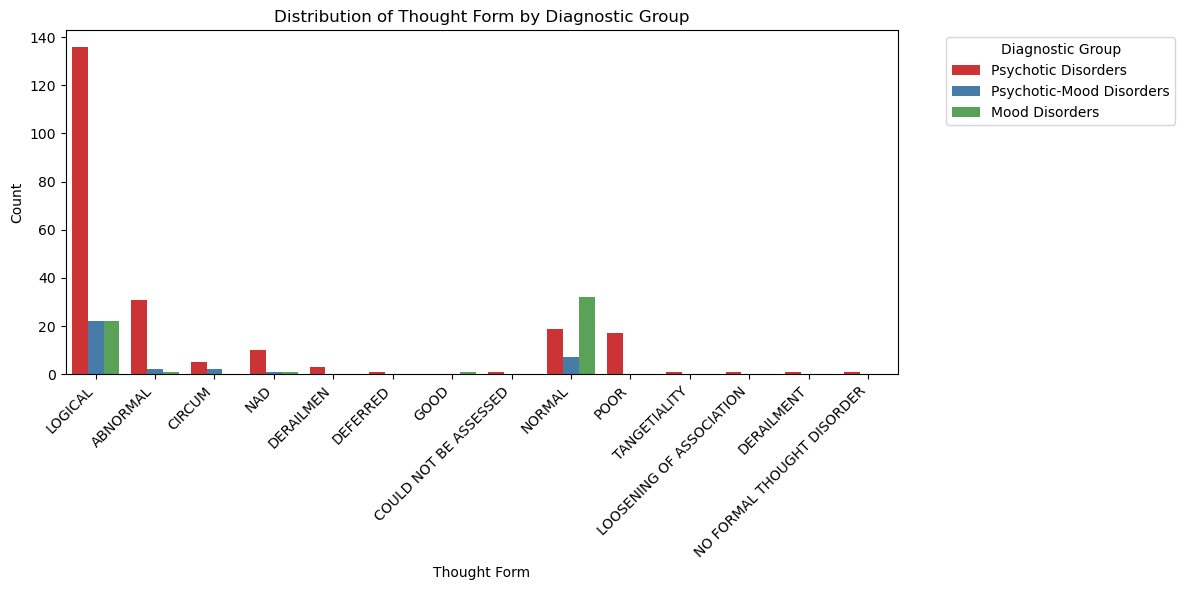

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure feature and target columns are strings
df['TH_FORM'] = df['TH_FORM'].astype(str)
df['DIAGN_GROUP'] = df['DIAGN_GROUP'].astype(str)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='TH_FORM', hue='DIAGN_GROUP', palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Thought Form by Diagnostic Group")
plt.xlabel("Thought Form")
plt.ylabel("Count")
plt.legend(title='Diagnostic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [4]:
# pip install xgboost

Complete ML Pipeline with Imbalance Handling

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# -----------------------
# In this cell, the 'Other_Medical' class was removed from the Target variable because it contained
#very few input (5 - Aneamia and Late Onset) and not really related to Psychiatric diagnosis. They were
#removed to avoid underfitting the models. Also, the results obtained showed the models demonstrated overfitting
#has class biased and the F1 was very low implying the model wasn't accurate enought.
# -----------------------


# -----------------------
# Step 1: Split data
# -----------------------


X = df.drop(columns=['DIAGN_GROUP'])
y = df['DIAGN_GROUP']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Encode string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# -----------------------
# Step 2: Preprocessing
# -----------------------

num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols)
])

# -----------------------
# Step 3: SMOTE + Class Weights Pipelines
# -----------------------

smote = SMOTE(random_state=42, k_neighbors=3)

models = {
    'Logistic Regression': ImbPipeline([
        ('pre', preprocessor),
        ('smote', smote),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    
    'SVC': ImbPipeline([
        ('pre', preprocessor),
        ('smote', smote),
        ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
    ]),
    
    'Random Forest': ImbPipeline([
        ('pre', preprocessor),
        ('smote', smote),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42))
    ]),
    
    'XGBoost': ImbPipeline([
        ('pre', preprocessor),
        ('smote', smote),
        ('clf', XGBClassifier(
    objective='multi:softprob',
    num_class=4,  # or len(np.unique(y_train_encoded))
    eval_metric='mlogloss',
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42

        ))
    ])
}

# -----------------------
# Step 4: Evaluate with CV
# -----------------------

print("Cross-validated F1-macro scores:\n")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train_encoded, cv=cv, scoring='f1_macro')
    print(f"{name:20s} | F1-macro: {scores.mean():.3f} ± {scores.std():.3f}")


Cross-validated F1-macro scores:

Logistic Regression  | F1-macro: 0.411 ± 0.031
SVC                  | F1-macro: 0.381 ± 0.051
Random Forest        | F1-macro: 0.431 ± 0.061
XGBoost              | F1-macro: 0.443 ± 0.058


In [6]:
print(f"Dataset shape: {X_train.shape}")

Dataset shape: (222, 35)


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# -----------------------
# In this cell, hypertuning has commenced. 
# OneHotEncoder: Converts categorical variables into a format that can be provided to 
# ML algorithms to do a better job in prediction.

# ColumnTransformer: Applies different preprocessing steps to different subsets of the 
# columns (i.e., categorical vs. numerical).
# -----------------------

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(with_mean=False), numeric_cols)
])


In [8]:
print("numeric_cols:", numeric_cols)
print("categorical_cols:", categorical_cols)


numeric_cols: ['YEAR', 'AGE', 'DUR_EPIS']
categorical_cols: ['SEX', 'PSE', 'MOOD', 'AFFECT', 'INSIGHT', 'TH_FORM', 'TH_CONTENT', 'TH_STRM', 'PERCEP', 'SPEECH', 'MEM_LT', 'MEM_ST', 'MEM_IR', 'CONC', 'ORIENT', 'ATTEN', 'JUDGMT', 'P_SEX_HX', 'P_MED_HX', 'PREMOBD_HX', 'P_PSY_HX', 'P_SOC_HX', 'FOR_HX', 'FAM_P_HX', 'EEG', 'INT_PROV', 'INT_CAL', 'INT_S_A_D', 'INT_GFK', 'MSE', 'MAR_STA', 'OCCUP']


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score

# Define the Common Scorer
f1_macro = make_scorer(f1_score, average='macro')


# Defining Pipeline and Grid parameters

# Logistic Regression
lr_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs']
}

# SVC
svc_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', SVC(class_weight='balanced', probability=True, random_state=42))
])

svc_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

# Random Forest
rf_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# XGBoost
xgb_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

xgb_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [4, 6],
    'clf__learning_rate': [0.1],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [1.0]
}





In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Preprocessing with imputation for missing values
preprocessor = ColumnTransformer(transformers=[
    # Add imputation for categorical columns before encoding
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent value
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    
    # Add imputation for numerical columns before scaling
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute with mean value
        ('scaler', StandardScaler(with_mean=False))
    ]), numeric_cols)
])

# Step 3: Create a full pipeline for one model (e.g. Logistic Regression)
pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    # Increase max_iter to give the algorithm more chances to converge
    ('clf', LogisticRegression(class_weight='balanced', max_iter=5000, tol=1e-4))
])

# Step 4: Define parameters - consider adding solver options if convergence issues persist
param_grid = {
    'clf__C': [0.1, 1, 10],
    # Optionally add different solvers to try
    'clf__solver': ['lbfgs', 'liblinear', 'saga']
}


# Step 5: GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro')

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring=f1_macro, n_jobs=-1)

# Step 6: Fit the pipeline
grid.fit(X_train, y_train_encoded)  # ← Now this will work

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['SEX',
                                                                          'PSE',
                                                                          'MOOD',
                                                                          'AFFECT',
                                                                          'INSIGHT',
                                                                          'TH_FORM',
                                                                          'TH_CONTENT',
                                                                          'TH_STRM',
                                                                          'PE...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler(with_mean=False))]),
                                                                         ['YEAR',
                                                                          'AGE',
                                                                          'DUR_EPIS'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__solver': ['lbfgs', 'liblinear', 'saga']},
             scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. Column selection
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Shared preprocessor (can reuse safely because steps are copied later)
preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler(with_mean=False))
    ]), numeric_cols)
])

# 3. Create base pipelines (without preprocessor added yet)
lr_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=5000))
])

rf_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier())
])

xgb_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(eval_metric='logloss'))

])

svc_pipe = ImbPipeline(steps=[
    #('smote', SMOTE(random_state=42)),
    ('clf', SVC(probability=True))
])



# 4. Parameter grids
lr_param_grid = {'clf__C': [0.01,0.1, 1, 10],
                'clf__penalty': ['l2'],
                'clf__solver': ['lbfgs']}

rf_param_grid = {'clf__n_estimators': [100, 200],
                'clf__max_depth': [None, 10,20],
                'clf__min_samples_split': [2,5]}

xgb_param_grid = {'clf__n_estimators': [100, 200],
                 'clf__min_samples_split': [4,6],
                 'clf__learning_rate': [0.1],
                 'clf__subsample': [0.8],
                 'clf__colsample_bytree': [1.0]}

svc_param_grid = {'clf__C': [0.1, 1, 10],
                 'clf__kernel': ['linear', 'rbf'],
                 'clf__gamma': ['scale', 'auto']}

# 5. Dictionary of models
models = {
    "Logistic Regression": (lr_pipe, lr_param_grid),
    "SVC": (svc_pipe, svc_param_grid),
    "Random Forest": (rf_pipe, rf_param_grid),
    "XGBoost": (xgb_pipe, xgb_param_grid)
}

# 6. Attach preprocessor with unique names to each pipeline
for name in models:
    pipe, param_grid = models[name]
    
    # Generate unique preprocessor name per model
    preprocessor_name = f'preprocessor_{name.lower().replace(" ", "_")}'
    
    # Add preprocessor if not already included
    step_names = [step[0] for step in pipe.steps]
    if preprocessor_name not in step_names:
        new_steps = [(preprocessor_name, preprocessor)] + pipe.steps
        new_pipe = ImbPipeline(steps=new_steps)
        models[name] = (new_pipe, param_grid)

# 7. Grid search
fitted_grids = {}

results = {}

for name, (pipe, param_grid) in models.items():
    print(f"\n🔍 Tuning: {name}")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring=f1_macro, n_jobs=-1)
    grid.fit(X_train, y_train_encoded)
    
    results[name] = {
        "Best F1-macro": grid.best_score_,
        "Best Params": grid.best_params_
    }
        # ✅ Save the fitted grid
    fitted_grids[name] = grid

    results[name] = {
        "Best F1-macro": grid.best_score_,
        "Best Params": grid.best_params_
    }
    
    print(f"✅ Best F1-macro: {grid.best_score_:.3f}")
    print(f"🔧 Best Params: {grid.best_params_}")



🔍 Tuning: Logistic Regression
✅ Best F1-macro: 0.622
🔧 Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

🔍 Tuning: SVC
✅ Best F1-macro: 0.609
🔧 Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

🔍 Tuning: Random Forest
✅ Best F1-macro: 0.639
🔧 Best Params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Tuning: XGBoost


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best F1-macro: 0.664
🔧 Best Params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__min_samples_split': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


In [12]:
import pandas as pd
import numpy as np
import gc  # For garbage collection

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. Column selection (same as before)
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Shared preprocessor function (creates fresh instance each time)
def create_preprocessor():
    return ColumnTransformer(transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),
        
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False))
        ]), numeric_cols)
    ])

# 3. Model configuration function
def get_model_config():
    return {
        "Logistic Regression": {
            'pipeline': lambda: ImbPipeline(steps=[
                ('preprocessor', create_preprocessor()),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(max_iter=5000))
            ]),
            'param_grid': {
                'clf__C': [0.01, 0.1, 1, 10],
                'clf__penalty': ['l2'],
                'clf__solver': ['lbfgs']
            }
        },
        
        "SVC": {
            'pipeline': lambda: ImbPipeline(steps=[
                ('preprocessor', create_preprocessor()),
                #('smote', SMOTE(random_state=42)),
                ('clf', SVC(probability=True))
            ]),
            'param_grid': {
                'clf__C': [0.1, 1, 10, 100],
                'clf__kernel': ['linear', 'rbf'],
                'clf__gamma': ['scale', 'auto', 0.001, 0.01]
            }
        },
        
        "Random Forest": {
            'pipeline': lambda: ImbPipeline(steps=[
                ('preprocessor', create_preprocessor()),
                ('smote', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier())
            ]),
            'param_grid': {
                'clf__n_estimators': [100, 200],
                'clf__max_depth': [None, 10, 20],
                'clf__min_samples_split': [2, 5]
            }
        },
        
        "XGBoost": {
            'pipeline': lambda: ImbPipeline(steps=[
                ('preprocessor', create_preprocessor()),
                ('smote', SMOTE(random_state=42)),
                ('clf', XGBClassifier(eval_metric='logloss'))
            ]),
            'param_grid': {
                'clf__n_estimators': [100, 200],
                'clf__min_child_weight': [4, 6],
                'clf__learning_rate': [0.1],
                'clf__subsample': [0.8],
                'clf__colsample_bytree': [1.0]
            }
        }
    }

# 4. Memory-efficient training function
def train_model_efficiently(model_name, config, X_train, y_train_encoded):
    """Train a single model with memory cleanup"""
    print(f"\n🔍 Tuning: {model_name}")
    print(f"📊 Memory usage before training...")
    
    # Create fresh pipeline instance
    pipe = config['pipeline']()
    param_grid = config['param_grid']
    
    # Setup cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro = make_scorer(f1_score, average='macro')
    
    # Grid search with reduced memory usage
    grid = GridSearchCV(
        pipe, 
        param_grid, 
        cv=cv, 
        scoring=f1_macro, 
        n_jobs=-1,
        verbose=1,  # Show progress
        return_train_score=False  # Save memory by not storing train scores
    )
    
    # Fit the model
    grid.fit(X_train, y_train_encoded)
    
    # Extract results
    results = {
        "Best F1-macro": grid.best_score_,
        "Best Params": grid.best_params_,
        "Best Estimator": grid.best_estimator_
    }
    
    fitted_grids[model_name] = grid.best_estimator_

    print(f" Best F1-macro: {grid.best_score_:.3f}")
    print(f" Best Params: {grid.best_params_}")
    
    # Clean up memory
    del pipe, grid
    gc.collect()
    
    return results

# 5. Run models sequentially (MEMORY EFFICIENT APPROACH)
def run_sequential_tuning(X_train, y_train_encoded):
    """Run model tuning one at a time to save memory"""
    model_configs = get_model_config()
    all_results = {}
    fitted_grids = {}
    
    for model_name, config in model_configs.items():
        # Train one model at a time
        result = train_model_efficiently(model_name, config, X_train, y_train_encoded)
        all_results[model_name] = result
        
        # If you need the fitted estimator later, store only the best one
        fitted_grids[model_name] = result["Best Estimator"]
        #fitted_grids[model_name] = grid.best_estimator_
        # Optional: Force garbage collection between models
        gc.collect()
        print(f"🧹 Memory cleaned after {model_name}")
    
    return all_results, fitted_grids

# 6. Alternative: Run specific models only
def run_single_model(model_name, X_train, y_train_encoded):
    """Run tuning for a single model"""
    model_configs = get_model_config()
    
    if model_name not in model_configs:
        print(f"❌ Model '{model_name}' not found. Available: {list(model_configs.keys())}")
        return None
    
    config = model_configs[model_name]
    return train_model_efficiently(model_name, config, X_train, y_train_encoded)

# 7. USAGE EXAMPLES:

# Option A: Run all models sequentially 
print("=" * 50)
print(" Starting Sequential Model Tuning")
print("=" * 50)
results, fitted_grids = run_sequential_tuning(X_train, y_train_encoded)

# Option B: Run individual models (for testing or if you want to run them separately)
# lr_result = run_single_model("Logistic Regression", X_train, y_train_encoded)
# svc_result = run_single_model("SVC", X_train, y_train_encoded)
# rf_result = run_single_model("Random Forest", X_train, y_train_encoded)
# xgb_result = run_single_model("XGBoost", X_train, y_train_encoded)

# 8. Display final results
print("\n" + "=" * 50)
print(" FINAL RESULTS SUMMARY")
print("=" * 50)
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"  Best F1-macro: {result['Best F1-macro']:.4f}")
    print(f"  Best Params: {result['Best Params']}")

# 9. Find best overall model
best_model = max(results.items(), key=lambda x: x[1]['Best F1-macro'])
print(f"\n BEST OVERALL MODEL: {best_model[0]}")
print(f" Best F1-macro Score: {best_model[1]['Best F1-macro']:.4f}")

🚀 Starting Sequential Model Tuning

🔍 Tuning: Logistic Regression
📊 Memory usage before training...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best F1-macro: 0.622
🔧 Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
🧹 Memory cleaned after Logistic Regression

🔍 Tuning: SVC
📊 Memory usage before training...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
✅ Best F1-macro: 0.657
🔧 Best Params: {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
🧹 Memory cleaned after SVC

🔍 Tuning: Random Forest
📊 Memory usage before training...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best F1-macro: 0.641
🔧 Best Params: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
🧹 Memory cleaned after Random Forest

🔍 Tuning: XGBoost
📊 Memory usage before training...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best F1-macro: 0.616
🔧 Best Params: {'clf__colsample_bytree': 1.0, 'clf__lear

In [13]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import os



# Get your model configuration
models = get_model_config()
#model_configs = get_model_config()

fitted_grids = {}
results = {}

for model_name, config in models.items():
    print(f"\n🔍 Tuning: {model_name}")
    
    # Extract pipeline and param_grid from the config dictionary
    pipe = config['pipeline']()  # Call the lambda function to get the pipeline
    param_grid = config['param_grid']
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_macro = make_scorer(f1_score, average='macro')
    
    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring=f1_macro, n_jobs=-1)
    grid.fit(X_train, y_train_encoded)
    
    # ✅ Save the fitted grid
    fitted_grids[model_name] = grid
    results[model_name] = {
        "Best F1-macro": grid.best_score_,
        "Best Params": grid.best_params_
    }

# Display results
print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"  Best F1-macro: {result['Best F1-macro']:.4f}")
    print(f"  Best Params: {result['Best Params']}")


def plot_and_save_roc(best_model, X_test, y_test, model_name, save_dir="roc_curves"):
    os.makedirs(save_dir, exist_ok=True)

    # Get unique class labels
    classes = np.unique(y_test)
    n_classes = len(classes)

    # Binarize the labels for multiclass ROC
    y_test_bin = label_binarize(y_test, classes=classes)
    y_score = best_model.predict_proba(X_test)  # must support predict_proba

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multiclass ROC Curve - {model_name}")
    plt.legend(loc="lower right")

    # Save the figure
    filename = f"{save_dir}/roc_curve_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.close()
    print(f"✅ ROC curve saved at: {filename}")



🔍 Tuning: Logistic Regression

🔍 Tuning: SVC

🔍 Tuning: Random Forest

🔍 Tuning: XGBoost

HYPERPARAMETER TUNING RESULTS

Logistic Regression:
  Best F1-macro: 0.6220
  Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

SVC:
  Best F1-macro: 0.6574
  Best Params: {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

Random Forest:
  Best F1-macro: 0.6239
  Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

XGBoost:
  Best F1-macro: 0.6161
  Best Params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__min_child_weight': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


In [14]:
for model_name, grid in fitted_grids.items():
    best_model = grid.best_estimator_
    try:
        plot_and_save_roc(best_model, X_test, y_test, model_name)
    except Exception as e:
        print(f"❌ Failed to plot ROC for {model_name}: {e}")


✅ ROC curve saved at: roc_curves/roc_curve_logistic_regression.png
✅ ROC curve saved at: roc_curves/roc_curve_svc.png
✅ ROC curve saved at: roc_curves/roc_curve_random_forest.png
✅ ROC curve saved at: roc_curves/roc_curve_xgboost.png


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [16]:
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred = best_model.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


In [17]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded)


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# decode if necessary
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred = best_model.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

cm = confusion_matrix(y_test_decoded, y_pred_decoded)


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_and_save_conf_matrix(y_test_decoded, y_pred_decoded, model_name, class_labels, save_dir="conf_matrices"):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the figure
    filename = f"{save_dir}/conf_matrix_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.close()  # Close the plot to free memory

    print(f"✅ Saved confusion matrix for {model_name} at: {filename}")


In [20]:
# Defining the actual class labels
class_labels = [ 'Mood Disorders', 'Psychotic Disorders', 'Psychotic-Mood Disorders']  

# Loop through models
for name, grid in fitted_grids.items():
    best_model = grid.best_estimator_
    # decode if necessary
    y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
    y_pred = best_model.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)

    plot_and_save_conf_matrix(y_test_decoded, y_pred_decoded, model_name=name, class_labels=class_labels)


✅ Saved confusion matrix for Logistic Regression at: conf_matrices/conf_matrix_logistic_regression.png
✅ Saved confusion matrix for SVC at: conf_matrices/conf_matrix_svc.png
✅ Saved confusion matrix for Random Forest at: conf_matrices/conf_matrix_random_forest.png
✅ Saved confusion matrix for XGBoost at: conf_matrices/conf_matrix_xgboost.png


### Add AUC values to a summary table

In [21]:
# To update the ROC Curves

def plot_and_save_roc(best_model, X_test, y_test, model_name, save_dir="roc_curves"):
    os.makedirs(save_dir, exist_ok=True)

    classes = np.unique(y_test)
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.vstack([1 - y_score, y_score]).T
    else:
        raise RuntimeError(f"{model_name} doesn't support ROC computation.")

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    macro_auc = np.mean(list(roc_auc.values()))

    # Plotting
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multiclass ROC - {model_name}")
    plt.legend(loc="lower right")
    filename = f"{save_dir}/roc_curve_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.close()

    print(f"✅ ROC saved at: {filename}")
    return macro_auc


In [22]:
summary = []

for model_name, grid in fitted_grids.items():
    best_model = grid.best_estimator_
    f1 = results[model_name]["Best F1-macro"]

    try:
        auc_score = plot_and_save_roc(best_model, X_test, y_test, model_name)
    except Exception as e:
        print(f"❌ Failed ROC for {model_name}: {e}")
        auc_score = None

    summary.append({
        "Model": model_name,
        "F1 Macro": f1,
        "Macro AUC": auc_score
    })


✅ ROC saved at: roc_curves/roc_curve_logistic_regression.png
✅ ROC saved at: roc_curves/roc_curve_svc.png
✅ ROC saved at: roc_curves/roc_curve_random_forest.png
✅ ROC saved at: roc_curves/roc_curve_xgboost.png


In [23]:
import pandas as pd
summary_df = pd.DataFrame(summary)
summary_df.sort_values(by="F1 Macro", ascending=False)


,Model,F1 Macro,Macro AUC
1,SVC,0.657396,0.810328
2,Random Forest,0.623940,0.865162
0,Logistic Regression,0.621986,0.758258
3,XGBoost,0.616114,0.831476


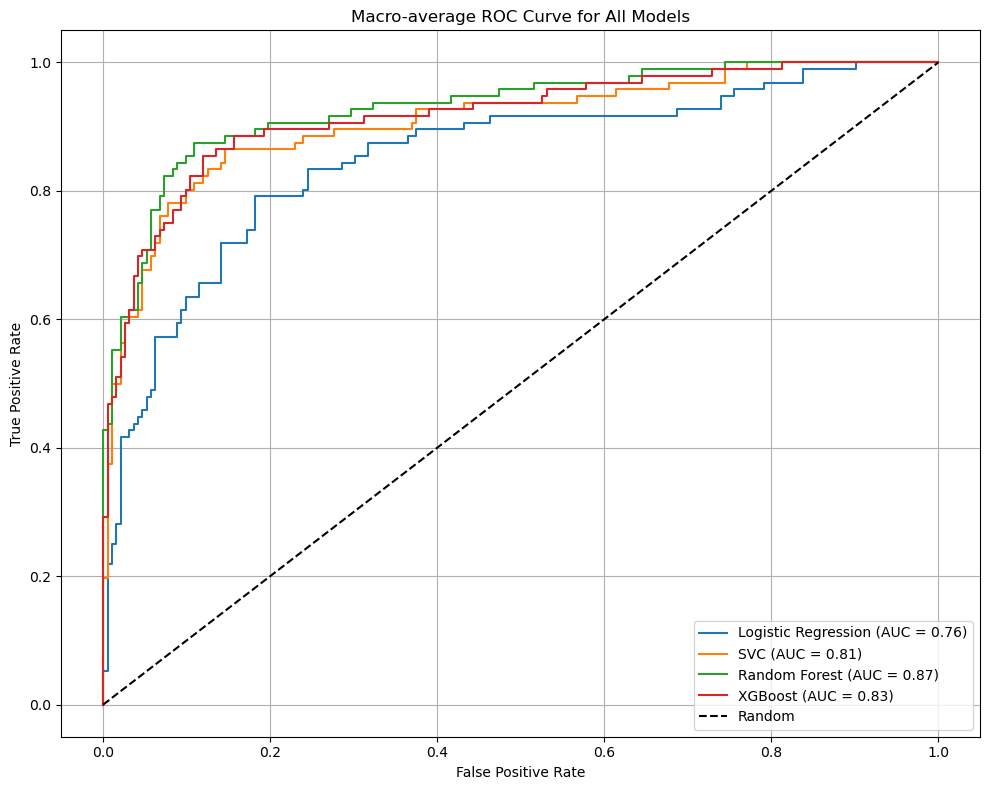

In [38]:
# To Plot all ROC curves on a single graph

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))


for model_name, grid in fitted_grids.items():
    best_model = grid.best_estimator_
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    try:
        if hasattr(best_model, "predict_proba"):
            y_score = best_model.predict_proba(X_test)
        else:
            y_score = best_model.decision_function(X_test)
            if y_score.ndim == 1:
                y_score = np.vstack([1 - y_score, y_score]).T

        # Compute ROC for each class
        roc_auc = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            auc_i = auc(fpr, tpr)
            roc_auc.append(auc_i)

        avg_auc = np.mean(roc_auc)
        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        plt.plot(fpr_micro, tpr_micro, label=f"{model_name} (AUC = {avg_auc:.2f})")
    
    except Exception as e:
        print(f"❌ Failed ROC plot for {model_name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
#filename = f"{save_dir}/roc_curve_{model_name.lower().replace(' ', '_')}.png"
#plt.savefig(filename)
plt.show()


In [25]:
# Since the overall AUC curve for Random Forest and XGBoost have the highest score. The models will be used with SHAP 
# to determine feature importance


#!pip install shap


In [26]:
import shap

# Random Forest
rf_model = fitted_grids["Random Forest"].best_estimator_
rf_clf = rf_model.named_steps["clf"]




In [28]:
 #To extract best model:


# Get the Random Forest model from your fitted grids
rf_model = fitted_grids["Random Forest"].best_estimator_

# Check the actual step names in your pipeline
print("Pipeline steps:", rf_model.named_steps.keys())

# Get the preprocessor
rf_preprocessor = rf_model.named_steps["preprocessor"]

# Properly transform X_test
X_rf_trans = rf_preprocessor.transform(X_test)

if hasattr(X_rf_trans, "toarray"):
    X_rf_trans = X_rf_trans.toarray()

# Ensure it's float type
X_rf_trans = X_rf_trans.astype("float64")

rf_explainer = shap.Explainer(rf_clf, X_rf_trans)
rf_shap_values = rf_explainer(X_rf_trans)

# Confirm shape
print("✅ X_rf_trans shape:", X_rf_trans.shape)  # Should be (78, 268)


Pipeline steps: dict_keys(['preprocessor', 'smote', 'clf'])
✅ X_rf_trans shape: (96, 243)


In [29]:
rf_explainer = shap.Explainer(rf_clf, X_rf_trans)
rf_shap_values = rf_explainer(X_rf_trans)


# Convert from per-sample format to per-class format (if needed)
if hasattr(rf_shap_values, 'values') and rf_shap_values.values.ndim == 3:
    # Reshape: from (n_samples, n_features, n_classes) to list of arrays
    shap_array = rf_shap_values.values
    rf_shap_values_reshaped = [shap_array[:, :, i] for i in range(shap_array.shape[2])]
    rf_shap_values = rf_shap_values_reshaped
    print("Reshaped RF SHAP values to per-class format")
    print("After reshape - len(rf_shap_values):", len(rf_shap_values))
    print("After reshape - rf_shap_values[0].shape:", rf_shap_values[0].shape)
elif hasattr(rf_shap_values, 'values'):
    # Already in correct format, just extract values
    rf_shap_values = rf_shap_values.values
    print("RF SHAP values shape:", rf_shap_values.shape)

Reshaped RF SHAP values to per-class format
After reshape - len(rf_shap_values): 3
After reshape - rf_shap_values[0].shape: (96, 243)


In [30]:
# SHAP RANDOM FOREST PLOT

import matplotlib.pyplot as plt

# SHAP RANDOM FOREST FOREST PLOT
# Step 1: Get all the final feature names
rf_feature_names_full = rf_preprocessor.get_feature_names_out()

# For RF - clean feature names
rf_clean_names = pd.Series(rf_feature_names_full).str.replace(r"^(cat|num)__", "", regex=True)
rf_base_names = rf_clean_names.str.replace(r"_(?!.*_).*", "", regex=True)

print(f"RF Feature names length: {len(rf_clean_names)}")

# Handle SHAP values based on format
if isinstance(rf_shap_values, list):
    # Multi-class: select class 0 from the list
    rf_shap_class0 = rf_shap_values[0]
    print(f"RF SHAP values (class 0) shape: {rf_shap_class0.shape}")
elif rf_shap_values.ndim == 3:
    # Multi-class: select class 0 from 3D array
    rf_shap_class0 = rf_shap_values[:, :, 0]
    print(f"RF SHAP values (class 0) shape: {rf_shap_class0.shape}")
else:
    # Binary classification
    rf_shap_class0 = rf_shap_values
    print(f"RF SHAP values shape: {rf_shap_class0.shape}")

# Create DataFrame with SHAP values
rf_df = pd.DataFrame(rf_shap_class0, columns=rf_clean_names)
rf_df.columns = rf_base_names

# Group by feature names (sum duplicate columns from one-hot encoding)
rf_grouped = rf_df.T.groupby(level=0).sum().T

print(f"RF Grouped features shape: {rf_grouped.shape}")
print(f"Top 10 most important features (by mean absolute SHAP):")
rf_feature_importance = rf_grouped.abs().mean().sort_values(ascending=False)
print(rf_feature_importance.head(10))

# Create SHAP summary plot
shap.summary_plot(
    rf_grouped.values,
     "This plot shows how each feature impacts the model prediction for this specific class.\n"
     "Red points indicate the feature value increases the prediction, blue indicates it decreases it.\n"
     "The x-axis shows whether the feature value is high (blue) or low (red) for that observation.",
    features=rf_grouped.values,  # Use same values for coloring
    feature_names=rf_grouped.columns.tolist(),
    show=False
)

# Save to file
plt.tight_layout()
plt.title("SHAP Summary Plot for Random Forest Model")
plt.savefig("shap_Random_Forest_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()

print("✅ Random Forest SHAP summary plot saved successfully!")

RF Feature names length: 243
RF SHAP values (class 0) shape: (96, 243)
RF Grouped features shape: (96, 35)
Top 10 most important features (by mean absolute SHAP):
PREMOBD_HX    0.038929
INSIGHT       0.031453
YEAR          0.019717
SEX           0.017970
AFFECT        0.017714
MOOD          0.016341
PSE           0.015269
MAR_STA       0.013621
TH_FORM       0.013608
PERCEP        0.013133
dtype: float64
✅ Random Forest SHAP summary plot saved successfully!


In [32]:
# SHAP PLOT FOR XGBOOST MODEL 

#To extract best model:
import shap


# XGBoost
xgb_model = fitted_grids["XGBoost"].best_estimator_
xgb_clf = xgb_model.named_steps["clf"]


In [33]:
# Get the preprocessor
xgb_preprocessor = xgb_model.named_steps["preprocessor"]

# Properly transform X_test
X_xgb_trans = xgb_preprocessor.transform(X_test)
if hasattr(X_xgb_trans, "toarray"):
    X_xgb_trans = X_xgb_trans.toarray()
    
# Ensure it's float type
X_xgb_trans = X_xgb_trans.astype("float64")

print("✅ X_xgb_trans shape:", X_xgb_trans.shape)  # Should be (78, 268)



✅ X_xgb_trans shape: (96, 243)


In [34]:
# Create SHAP explainer and get values
xgb_explainer = shap.Explainer(xgb_clf, X_xgb_trans)
xgb_shap_values = xgb_explainer(X_xgb_trans)

# Convert from per-sample format to per-class format
if len(xgb_shap_values) == X_xgb_trans.shape[0]:  # 78 samples
    # Reshape: from (78, 268, 5) to list of 5 arrays of (78, 268)
    shap_array = np.array(xgb_shap_values.values)  # Get values from Explanation object first
    xgb_shap_values_reshaped = [shap_array[:, :, i] for i in range(shap_array.shape[2])]
    xgb_shap_values = xgb_shap_values_reshaped
    
print("After reshape - len(xgb_shap_values):", len(xgb_shap_values))
print("After reshape - xgb_shap_values[0].shape:", xgb_shap_values[0].shape)


After reshape - len(xgb_shap_values): 3
After reshape - xgb_shap_values[0].shape: (96, 243)


In [35]:

# SHAP XGBoost PLOT
# Step 1: Get all the final feature names
xgb_feature_names_full = xgb_preprocessor.get_feature_names_out()

# For XGBoost - clean feature names
xgb_clean_names = pd.Series(xgb_feature_names_full).str.replace(r"^(cat|num)__", "", regex=True)
xgb_base_names = xgb_clean_names.str.replace(r"_(?!.*_).*", "", regex=True)

print(f"Feature names length: {len(xgb_clean_names)}")
print(f"SHAP values shape: {xgb_shap_values[0].shape}")

# Use the reshaped list directly (it's now a list of numpy arrays)
xgb_shap_class0 = xgb_shap_values[0]  # Select class 0 from the list

# Create DataFrame with SHAP values
xgb_df = pd.DataFrame(xgb_shap_class0, columns=xgb_clean_names)
xgb_df.columns = xgb_base_names

# Group by feature names (sum duplicate columns from one-hot encoding)
xgb_grouped = xgb_df.T.groupby(level=0).sum().T

print(f"Grouped features shape: {xgb_grouped.shape}")
print(f"Top 10 most important features (by mean absolute SHAP):")
feature_importance = xgb_grouped.abs().mean().sort_values(ascending=False)
print(feature_importance.head(10))

# Create SHAP summary plot
shap.summary_plot(
    xgb_grouped.values,
    features=xgb_grouped.values,  # Use same values for coloring
    feature_names=xgb_grouped.columns.tolist(),
    show=False
)

# Save to file
plt.tight_layout()
plt.title("SHAP Summary Plot for XGBoost Model")
plt.savefig("shap_XGBoost_Model_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()

print("✅ SHAP summary plot saved successfully!")

Feature names length: 243
SHAP values shape: (96, 243)
Grouped features shape: (96, 35)
Top 10 most important features (by mean absolute SHAP):
INSIGHT       0.496499
TH_CONTENT    0.452430
PREMOBD_HX    0.261168
DUR           0.193562
YEAR          0.187037
MEM_ST        0.167972
PERCEP        0.135759
JUDGMT        0.132998
P_MED_HX      0.129638
MOOD          0.129315
dtype: float64
✅ SHAP summary plot saved successfully!


In [36]:
# LOGISTIC REGRESSION MODEL
# =============================================================================

# Logistic Regression
lr_model = fitted_grids["Logistic Regression"].best_estimator_
lr_clf = lr_model.named_steps["clf"]

# Get the preprocessor
lr_preprocessor = lr_model.named_steps["preprocessor"]
# Properly transform X_test
X_lr_trans = lr_preprocessor.transform(X_test)
if hasattr(X_lr_trans, "toarray"):
    X_lr_trans = X_lr_trans.toarray()
    
# Ensure it's float type
X_lr_trans = X_lr_trans.astype("float64")
print("✅ X_lr_trans shape:", X_lr_trans.shape)  # Should be (78, 268)

# Create SHAP explainer for Logistic Regression
# LinearExplainer is ideal for logistic regression
lr_explainer = shap.LinearExplainer(lr_clf, X_lr_trans)
lr_shap_values = lr_explainer.shap_values(X_lr_trans)

# Handle multi-class output format
if isinstance(lr_shap_values, list):
    # Already in per-class format
    print("LR SHAP values already in per-class format")
    print("Number of classes:", len(lr_shap_values))
    print("Shape per class:", lr_shap_values[0].shape)
else:
    # Convert from per-sample format to per-class format if needed
    if len(lr_shap_values.shape) == 3:  # (samples, features, classes)
        lr_shap_values = [lr_shap_values[:, :, i] for i in range(lr_shap_values.shape[2])]
    else:
        # Binary classification case
        lr_shap_values = [lr_shap_values]

print("After processing - len(lr_shap_values):", len(lr_shap_values))
print("After processing - lr_shap_values[0].shape:", lr_shap_values[0].shape)

# SHAP Logistic Regression PLOT
# Step 1: Get all the final feature names
lr_feature_names_full = lr_preprocessor.get_feature_names_out()
# For Logistic Regression - clean feature names
lr_clean_names = pd.Series(lr_feature_names_full).str.replace(r"^(cat|num)__", "", regex=True)
lr_base_names = lr_clean_names.str.replace(r"_(?!.*_).*", "", regex=True)
print(f"Feature names length: {len(lr_clean_names)}")
print(f"SHAP values shape: {lr_shap_values[0].shape}")

# Use class 0 SHAP values (or adjust class index as needed)
lr_shap_class0 = lr_shap_values[0]  # Select class 0
# Create DataFrame with SHAP values
lr_df = pd.DataFrame(lr_shap_class0, columns=lr_clean_names)
lr_df.columns = lr_base_names
# Group by feature names (sum duplicate columns from one-hot encoding)
lr_grouped = lr_df.T.groupby(level=0).sum().T
print(f"Grouped features shape: {lr_grouped.shape}")
print(f"Top 10 most important features (by mean absolute SHAP):")
feature_importance = lr_grouped.abs().mean().sort_values(ascending=False)
print(feature_importance.head(10))

# Create SHAP summary plot for Logistic Regression
shap.summary_plot(
    lr_grouped.values,
    features=lr_grouped.values,  # Use same values for coloring
    feature_names=lr_grouped.columns.tolist(),
    show=False
)
# Save to file
plt.tight_layout()
plt.title("SHAP Summary Plot for Logistic Regression Model")
plt.savefig("shap_LogisticRegression_Model_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()
print("✅ Logistic Regression SHAP summary plot saved successfully!")

✅ X_lr_trans shape: (96, 243)
After processing - len(lr_shap_values): 3
After processing - lr_shap_values[0].shape: (96, 243)
Feature names length: 243
SHAP values shape: (96, 243)
Grouped features shape: (96, 35)
Top 10 most important features (by mean absolute SHAP):
AFFECT        0.596623
PREMOBD_HX    0.525350
INSIGHT       0.510597
MAR_STA       0.499739
SEX           0.444155
OCCUP         0.407579
PSE           0.332414
P_MED_HX      0.331356
PERCEP        0.327754
P_PSY_HX      0.274261
dtype: float64
✅ Logistic Regression SHAP summary plot saved successfully!


In [37]:
# SUPPORT VECTOR CLASSIFICATION (SVC) MODEL
# =============================================================================

# SVC
svc_model = fitted_grids["SVC"].best_estimator_
svc_clf = svc_model.named_steps["clf"]

# Get the preprocessor
svc_preprocessor = svc_model.named_steps["preprocessor"]
# Properly transform X_test
X_svc_trans = svc_preprocessor.transform(X_test)
if hasattr(X_svc_trans, "toarray"):
    X_svc_trans = X_svc_trans.toarray()
    
# Ensure it's float type
X_svc_trans = X_svc_trans.astype("float64")
print("✅ X_svc_trans shape:", X_svc_trans.shape)  # Should be (78, 268)

# Debug: Check model and data shapes
print("SVC model type:", type(svc_clf))
print("SVC kernel:", getattr(svc_clf, 'kernel', 'Unknown'))
print("X_svc_trans shape:", X_svc_trans.shape)
if hasattr(svc_clf, 'coef_'):
    print("SVC coef_ shape:", svc_clf.coef_.shape)
if hasattr(svc_clf, 'n_features_in_'):
    print("SVC n_features_in_:", svc_clf.n_features_in_)

# Create SHAP explainer for SVC
# Use the same approach as XGBoost for consistency
try:
    # Method 1: Try the general Explainer (similar to XGBoost approach)
    print("Trying general shap.Explainer...")
    svc_explainer = shap.Explainer(svc_clf, X_svc_trans)
    svc_shap_values = svc_explainer(X_svc_trans)
    print("✅ General Explainer worked!")
    
    # Convert from Explanation object to numpy arrays if needed
    if hasattr(svc_shap_values, 'values'):
        if len(svc_shap_values.values.shape) == 3:  # (samples, features, classes)
            shap_array = svc_shap_values.values
            svc_shap_values = [shap_array[:, :, i] for i in range(shap_array.shape[2])]
        else:
            svc_shap_values = [svc_shap_values.values]
    
except Exception as e:
    print(f"General Explainer failed: {e}")
    
    try:
        # Method 2: Try KernelExplainer as fallback
        print("Trying KernelExplainer...")
        background_size = min(50, X_svc_trans.shape[0])  # Smaller background for speed
        background = shap.sample(X_svc_trans, background_size)
        svc_explainer = shap.KernelExplainer(svc_clf.predict_proba, background)
        svc_shap_values = svc_explainer.shap_values(X_svc_trans[:20])  # Use subset for speed
        print("✅ KernelExplainer worked!")
        
    except Exception as e2:
        print(f"KernelExplainer also failed: {e2}")
        
        try:
            # Method 3: Try PermutationExplainer
            print("Trying PermutationExplainer...")
            svc_explainer = shap.PermutationExplainer(svc_clf.predict_proba, X_svc_trans[:50])
            svc_shap_values = svc_explainer.shap_values(X_svc_trans[:20])
            print("✅ PermutationExplainer worked!")
            
        except Exception as e3:
            print(f"All explainer methods failed. Error: {e3}")
            print("Skipping SVC SHAP analysis...")
            svc_shap_values = None

# Only proceed if SHAP values were successfully generated
if svc_shap_values is not None:
    # Handle multi-class output format
    if isinstance(svc_shap_values, list):
        # Already in per-class format
        print("SVC SHAP values already in per-class format")
        print("Number of classes:", len(svc_shap_values))
        print("Shape per class:", svc_shap_values[0].shape)
    else:
        # Convert from per-sample format to per-class format if needed
        if len(svc_shap_values.shape) == 3:  # (samples, features, classes)
            svc_shap_values = [svc_shap_values[:, :, i] for i in range(svc_shap_values.shape[2])]
        else:
            # Binary classification case
            svc_shap_values = [svc_shap_values]

    print("After processing - len(svc_shap_values):", len(svc_shap_values))
    print("After processing - svc_shap_values[0].shape:", svc_shap_values[0].shape)

    # SHAP SVC PLOT
    # Step 1: Get all the final feature names
    svc_feature_names_full = svc_preprocessor.get_feature_names_out()
    # For SVC - clean feature names
    svc_clean_names = pd.Series(svc_feature_names_full).str.replace(r"^(cat|num)__", "", regex=True)
    svc_base_names = svc_clean_names.str.replace(r"_(?!.*_).*", "", regex=True)
    print(f"Feature names length: {len(svc_clean_names)}")
    print(f"SHAP values shape: {svc_shap_values[0].shape}")

    # Use class 0 SHAP values (or adjust class index as needed)
    svc_shap_class0 = svc_shap_values[0]  # Select class 0
    # Create DataFrame with SHAP values
    svc_df = pd.DataFrame(svc_shap_class0, columns=svc_clean_names)
    svc_df.columns = svc_base_names
    # Group by feature names (sum duplicate columns from one-hot encoding)
    svc_grouped = svc_df.T.groupby(level=0).sum().T
    print(f"Grouped features shape: {svc_grouped.shape}")
    print(f"Top 10 most important features (by mean absolute SHAP):")
    feature_importance = svc_grouped.abs().mean().sort_values(ascending=False)
    print(feature_importance.head(10))

    # Create SHAP summary plot for SVC
    shap.summary_plot(
        svc_grouped.values,
        features=svc_grouped.values,  # Use same values for coloring
        feature_names=svc_grouped.columns.tolist(),
        show=False
    )
    # Save to file
    plt.tight_layout()
    plt.title("SHAP Summary Plot for SVC Model")
    plt.savefig("shap_SVC_Model_summary_plot.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ SVC SHAP summary plot saved successfully!")
else:
    print("❌ SVC SHAP analysis skipped due to explainer issues")
    svc_grouped = None

✅ X_svc_trans shape: (96, 243)
SVC model type: <class 'sklearn.svm._classes.SVC'>
SVC kernel: rbf
X_svc_trans shape: (96, 243)
SVC n_features_in_: 243
Trying general shap.Explainer...
General Explainer failed: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVC(C=100, gamma=0.01, probability=True)
Trying KernelExplainer...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ KernelExplainer worked!
After processing - len(svc_shap_values): 3
After processing - svc_shap_values[0].shape: (20, 243)
Feature names length: 243
SHAP values shape: (20, 243)
Grouped features shape: (20, 35)
Top 10 most important features (by mean absolute SHAP):
YEAR          0.046099
DUR           0.030217
MAR_STA       0.029152
AFFECT        0.025868
PREMOBD_HX    0.017372
INSIGHT       0.015402
OCCUP         0.014865
MOOD          0.011268
TH_FORM       0.011212
TH_CONTENT    0.008132
dtype: float64
✅ SVC SHAP summary plot saved successfully!
